In [1]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker

config = get_config()
conn_dir = config["connectivity_matrices"]

REFNET = ("Default",)
INTER = ("Default",)

sns.reset_defaults()

In [2]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"], k=k, feat="fc", atlas=ATLAS, groupkfold=False, net="".join(REFNET), inter="".join(INTER)
)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


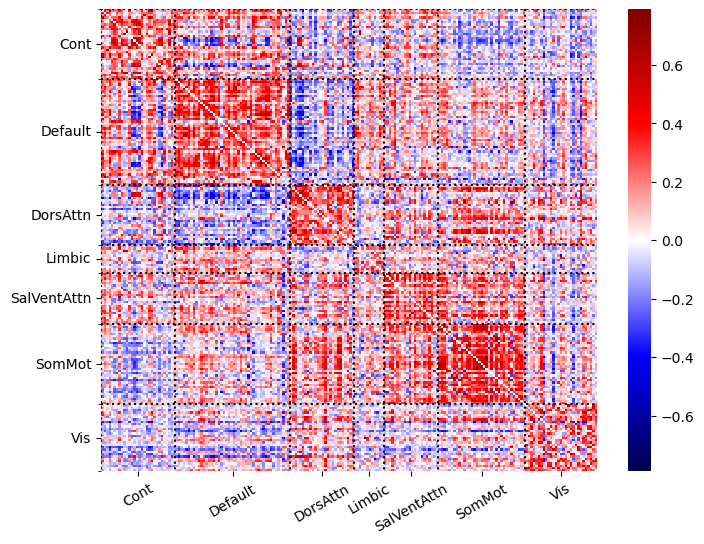

In [3]:
from neuroginius.atlas import Atlas
plot_matrix(matrices[1], Atlas.from_name(ATLAS))
plt.show()

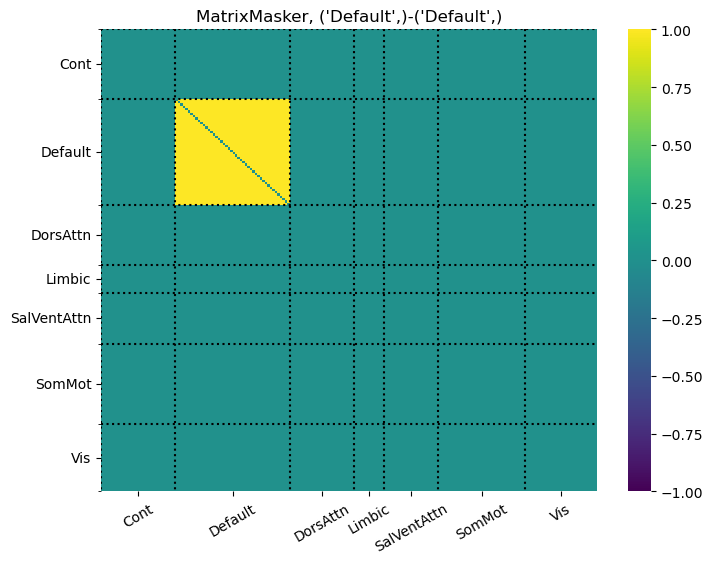

In [4]:
masker = MatrixMasker(REFNET, INTER).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

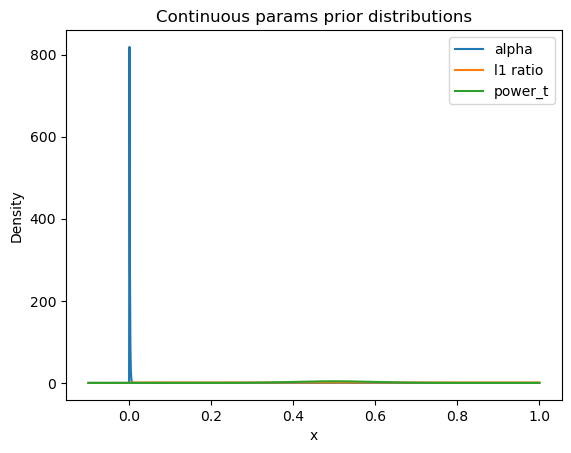

In [5]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [6]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER)),
    ("scaler", preprocessing.StandardScaler()),
    #("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [8]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
68,4.178810,1.529136,0.053676,0.002440,0.000971,0.993877,log_loss,0.508933,"{'classifier__alpha': 0.0009713204162961679, '...",0.401097,0.382710,0.364550,0.398400,0.341905,0.355870,0.404649,0.367055,0.377030,0.021702,1
85,1.514527,0.139419,0.051948,0.002239,0.001556,0.831881,hinge,0.463549,"{'classifier__alpha': 0.0015558543504468295, '...",0.384743,0.367460,0.357436,0.477065,0.313178,0.384087,0.330197,0.401908,0.377009,0.046745,2
40,1.259034,0.101167,0.055937,0.007156,0.000678,0.802044,hinge,0.416823,"{'classifier__alpha': 0.000678403838382071, 'c...",0.403300,0.371420,0.382682,0.458917,0.324217,0.371234,0.316117,0.371315,0.374900,0.041816,3
84,1.600394,0.119444,0.051563,0.003198,0.000629,0.934478,log_loss,0.570189,"{'classifier__alpha': 0.0006289213216108742, '...",0.377243,0.343811,0.355661,0.453860,0.294504,0.382051,0.375685,0.400876,0.372961,0.042920,4
78,1.924151,0.162252,0.055531,0.002526,0.001798,0.890041,hinge,0.625186,"{'classifier__alpha': 0.0017975202621170992, '...",0.373212,0.349668,0.343745,0.448953,0.308620,0.377208,0.334473,0.444444,0.372541,0.047327,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1.089271,0.094988,0.056294,0.007360,0.000080,0.691335,hinge,0.557582,"{'classifier__alpha': 8.005084102476663e-05, '...",0.349349,0.348810,0.316563,0.343830,0.343777,0.361466,0.334863,0.352697,0.343919,0.012593,96
44,1.145091,0.075888,0.054754,0.004033,0.000368,0.668146,hinge,0.603524,"{'classifier__alpha': 0.0003676740508154635, '...",0.348148,0.367372,0.302493,0.339830,0.355149,0.375062,0.304416,0.355160,0.343454,0.025204,97
31,1.342596,0.066627,0.052773,0.002568,0.000575,0.725686,log_loss,0.697257,"{'classifier__alpha': 0.0005752076425649398, '...",0.364758,0.373517,0.304680,0.333564,0.338641,0.360644,0.324994,0.341015,0.342727,0.021272,98
58,1.244094,0.130616,0.051775,0.001671,0.001071,0.683930,hinge,0.423776,"{'classifier__alpha': 0.0010710241069441318, '...",0.341782,0.364142,0.315606,0.340537,0.323137,0.346883,0.320563,0.382993,0.341955,0.021531,99


In [9]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [10]:
def net_select(label):
    if label == masker.refnet[0]:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network == masker.refnet[0]:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

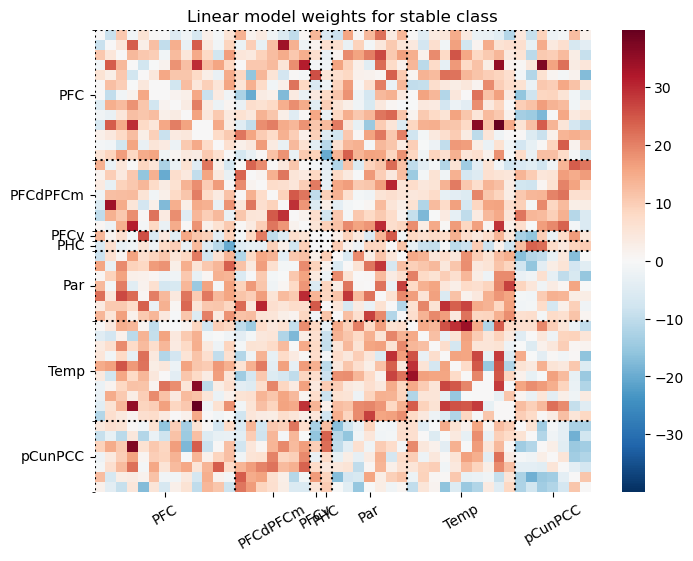

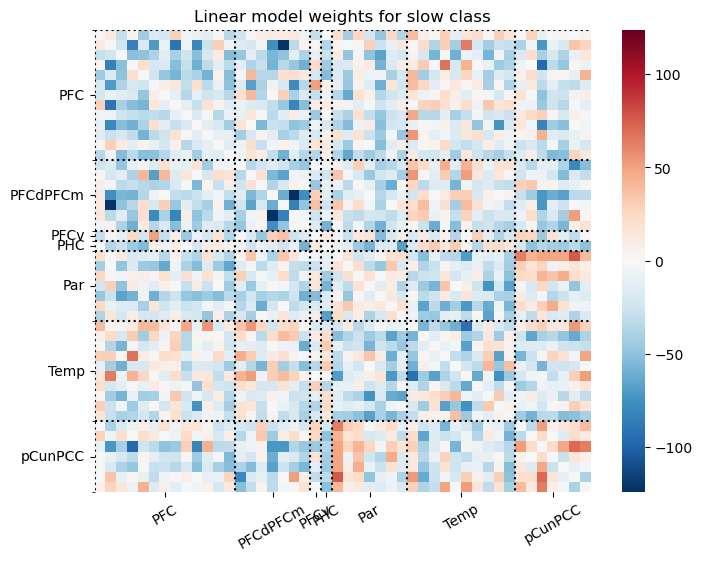

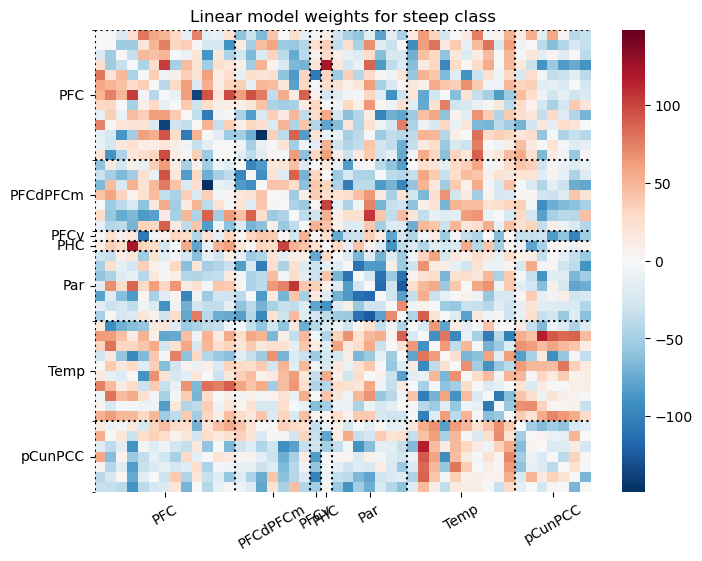

In [12]:
from nilearn.connectome import vec_to_sym_matrix
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, regions))
    
# TODO What would happen if we inverse-transformed the coefs?
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    X = est.named_steps["scaler"].transform(X)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        #bounds=(-4, 4)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [13]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.40176822, 0.43905724, 0.31365079, 0.33749873, 0.28703466,
       0.29779964, 0.31430408, 0.31323824])

In [14]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_groupkfold-False_net-Default_inter-Default/best_estimator.joblib']